In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from torchmetrics import AUROC
from pytorch_lightning.callbacks import RichProgressBar
#from pytorch_lightning.metrics.functional.classification import auroc
from sklearn.model_selection import train_test_split

print("importation fini")

importation fini


In [2]:
df = pd.read_csv("content/train-3.csv")

In [3]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.1


df chargé
 echantillon fait 


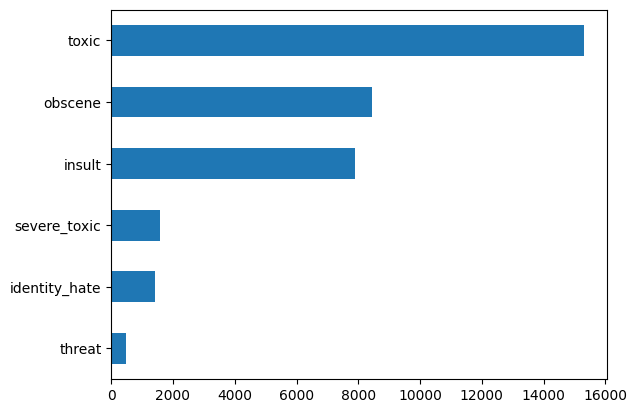

In [4]:
print('df chargé')
df.head()

df.shape

df.isnull().sum()

train_df, test_df = train_test_split(df, test_size=0.1)
train_df.shape, test_df.shape

CLASSES = df.columns.to_list()[2:]
CLASSES

df[CLASSES].sum().sort_values().plot(kind="barh")

df[CLASSES].sum(), df.shape

toxic_df = df[df[CLASSES].sum(axis=1) > 0]
toxic_df.shape

# commentaire jugé clean ( no hate)
clean_df = df[df[CLASSES].sum(axis=1) == 0]
clean_df.shape

#pour &quilibrer un peu les donnees
clean_df = clean_df.sample(16_000)
clean_df.shape

# prendre un echantillons "équilibré" entre clean et hate comms
train_df = pd.concat([toxic_df, clean_df])
train_df.shape

train_df[CLASSES].sum()
print(" echantillon fait ")

In [5]:
BERT_MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [6]:
"""###**Dataset Preparation**"""

class ToxicCommentsDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_len: int = 128
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        single_row = self.data.iloc[index]

        comment = single_row.comment_text
        labels = single_row[CLASSES]

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            "comment_text": comment,
            "input_ids": encoding["input_ids"].flatten(), # [1,512] => [512]
            "attention_mask": encoding["attention_mask"].flatten(), # [1,512] => [512]
            "labels": torch.FloatTensor(labels)
        }

In [7]:
train_dataset = ToxicCommentsDataset(train_df, tokenizer)

sample_data = train_dataset[0]

print(sample_data["comment_text"])
print()
print(sample_data["input_ids"])
print()
print(sample_data["attention_mask"])
print()
print(sample_data["labels"])


COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

tensor([  101, 18732,  1658, 25370, 21986, 22441,  2069,   139, 14663,  9565,
         2036, 19141,   153,  6258,  1708, 22133,  2346, 27370,  2137, 21748,
          150,  3663,   160,  9565,  2428,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,    

/tmp/ipykernel_179983/4020562342.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "labels": torch.FloatTensor(labels)


In [8]:
class ToxicCommentDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_len=128):
        super().__init__()

        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_len = max_len

    def setup(self,stage=None):
        self.train_dataset = ToxicCommentsDataset(self.train_df, self.tokenizer, self.max_len)
        self.test_dataset = ToxicCommentsDataset(self.test_df, self.tokenizer, self.max_len)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            num_workers=4
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            num_workers=4
        )

In [9]:
EPOCHS = 20
BATCH_SIZE = 32

In [10]:
data_module = ToxicCommentDataModule(
    train_df,
    test_df,
    tokenizer,
    batch_size=BATCH_SIZE
)
data_module.setup()

In [11]:
"""###**MODEL BUILDING**"""

class ToxicCommentClassifier(pl.LightningModule):
    def __init__(self, n_classes: int, steps_per_epoch=None, n_epochs=None):
        super().__init__()

        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {
            "loss": loss,
            "predictions": outputs,
            "labels": labels
        }

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

   

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        warmup_steps = self.steps_per_epoch // 3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps
        scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer], [scheduler]

In [12]:
model = ToxicCommentClassifier(
    n_classes=len(CLASSES),
    steps_per_epoch=len(train_df)//BATCH_SIZE,
    n_epochs=EPOCHS
)

print("Model et tokenizer initialisés")

Model et tokenizer initialisés


In [13]:

trainer = pl.Trainer(max_epochs=EPOCHS, accelerator='gpu', callbacks=[RichProgressBar()])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/c/Users/AREZKI/Documents/Etud/M2-I2A/Hackathon/filtrage_gpu_torch/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [14]:
trainer.fit(model, data_module)
print("l'entrainement est fini")

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/mnt/c/Users/AREZKI/Documents/Etud/M2-I2A/Hackathon/filtrage_gpu_torch/env/lib/python3.10/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type      ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ bert       │ BertModel │  108 M │
│ 1 │ classifier │ Linear    │  4.6 K │
│ 2 │ criterion  │ BCELoss   │      0 │
└───┴────────────┴───────────┴────────┘

Trainable params: 108 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 108 M                                                                                                
Total estimated model params size (MB): 433

Output()

In [ ]:
#torch.save(model.state_dict(), 'modele2_pl.pt')
print("le model est saved")

In [1]:
trainer.test()

trainer.save_checkpoint("last-checkpoint.ckpt")
trainer.save("/train")
print("saved")

NameError: name 'trainer' is not defined